<a href="https://colab.research.google.com/github/bhardwaj1230/Hierarchical-Deep-Reinforcement-Learning/blob/master/MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MDP**

In [0]:
!git clone https://github.com/transedward/pytorch-hdqn.git
import os 
os.chdir('./pytorch-hdqn/')

Cloning into 'pytorch-hdqn'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


**HDQN**

In [0]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

import torch.optim as optim

from envs.mdp import StochasticMDPEnv
from agents.hdqn_mdp import hDQN, OptimizerSpec
from utils.plotting import plot_episode_stats, plot_visited_states
from utils.schedule import LinearSchedule

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


NUM_EPISODES = 15000
BATCH_SIZE = 128
GAMMA = 1.0
REPLAY_MEMORY_SIZE = 1000000
LEARNING_RATE = 0.00025
ALPHA = 0.95
EPS = 0.01

optimizer_spec = OptimizerSpec(
    constructor=optim.RMSprop,
    kwargs=dict(lr=LEARNING_RATE, alpha=ALPHA, eps=EPS),
)

exploration_schedule = LinearSchedule(50000, 0.1, 1)

agent = hDQN(
    optimizer_spec=optimizer_spec,
    replay_memory_size=REPLAY_MEMORY_SIZE,
    batch_size=BATCH_SIZE,
)

env = StochasticMDPEnv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import numpy as np
from collections import defaultdict
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from utils.replay_memory import ReplayMemory
from utils import plotting

torch.manual_seed(0)
import numpy as np
np.random.seed(0)
from tqdm import tqdm

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

class Variable(autograd.Variable):
    def __init__(self, data, *args, **kwargs):
        if USE_CUDA:
            data = data.cuda()
        super(Variable, self).__init__(data, *args, **kwargs)

def one_hot_state(state):
    vector = np.zeros(6)
    vector[state-1] = 1.0
    return np.expand_dims(vector, axis=0)

def one_hot_goal(goal):
    vector = np.zeros(6)
    vector[goal-1] = 1.0
    return np.expand_dims(vector, axis=0)

def hdqn_learning(
    env,
    agent,
    num_episodes,
    exploration_schedule,
    gamma=1.0,
    ):

    """The h-DQN learning algorithm.
    All schedules are w.r.t. total number of steps taken in the environment.
    Parameters
    ----------
    env: gym.Env
        gym environment to train on.
    agent:
        a h-DQN agent consists of a meta-controller and controller.
    num_episodes:
        Number (can be divided by 1000) of episodes to run for. Ex: 12000
    exploration_schedule: Schedule (defined in utils.schedule)
        schedule for probability of chosing random action.
    gamma: float
        Discount Factor
    """
    ###############
    # RUN ENV     #
    ###############
    # Keep track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    n_thousand_episode = int(np.floor(num_episodes / 1000))
    visits = np.zeros((n_thousand_episode, env.nS))
    total_timestep = 0
    meta_timestep = 0
    ctrl_timestep = defaultdict(int)

    for i_thousand_episode in range(n_thousand_episode):
        for i_episode in tqdm(range(1000)):
            episode_length = 0
            current_state = env.reset()
            visits[i_thousand_episode][current_state-1] += 1
            encoded_current_state = one_hot_state(current_state)

            done = False
            while not done:
                meta_timestep += 1
                # Get annealing exploration rate (epislon) from exploration_schedule
                meta_epsilon = exploration_schedule.value(total_timestep)
                goal = agent.select_goal(encoded_current_state, meta_epsilon)[0]
                encoded_goal = one_hot_goal(goal)

                total_extrinsic_reward = 0
                goal_reached = False
                while not done and not goal_reached:
                    total_timestep += 1
                    episode_length += 1
                    ctrl_timestep[goal] += 1
                    # Get annealing exploration rate (epislon) from exploration_schedule
                    ctrl_epsilon = exploration_schedule.value(total_timestep)
                    joint_state_goal = np.concatenate([encoded_current_state, encoded_goal], axis=1)
                    action = agent.select_action(joint_state_goal, ctrl_epsilon)[0]
                    ### Step the env and store the transition
                    next_state, extrinsic_reward, done, _ = env.step(action)
                    # Update statistics
                    stats.episode_rewards[i_thousand_episode*1000 + i_episode] += extrinsic_reward
                    stats.episode_lengths[i_thousand_episode*1000 + i_episode] = episode_length
                    visits[i_thousand_episode][next_state-1] += 1

                    encoded_next_state = one_hot_state(next_state)
                    intrinsic_reward = agent.get_intrinsic_reward(goal, next_state)
                    goal_reached = next_state == goal

                    joint_next_state_goal = np.concatenate([encoded_next_state, encoded_goal], axis=1)
                    agent.ctrl_replay_memory.push(joint_state_goal, action, joint_next_state_goal, intrinsic_reward, done)
                    # Update Both meta-controller and controller
                    agent.update_meta_controller(gamma)
                    agent.update_controller(gamma)

                    total_extrinsic_reward += extrinsic_reward
                    current_state = next_state
                    encoded_current_state = encoded_next_state
                # Goal Finished
                agent.meta_replay_memory.push(encoded_current_state, goal, encoded_next_state, total_extrinsic_reward, done)

    return agent, stats, visits


In [0]:
agent, stats, visits = hdqn_learning(
    env=env,
    agent=agent,
    num_episodes=NUM_EPISODES,
    exploration_schedule=exploration_schedule,
    gamma=GAMMA,
)

In [0]:
visits

array([[1000., 1337.,  440.,  131.,   41.,   13.],
       [1000., 1374.,  503.,  177.,   69.,   21.],
       [1000., 1355.,  466.,  139.,   38.,   10.],
       [1000., 1314.,  413.,  130.,   34.,    3.],
       [1000., 1370.,  500.,  168.,   59.,   21.],
       [1000., 1387.,  502.,  152.,   45.,    8.],
       [1000., 1353.,  480.,  179.,   64.,   12.],
       [1000., 1398.,  518.,  139.,   28.,    9.],
       [1000., 1436.,  569.,  173.,   52.,   12.],
       [1000., 1387.,  536.,  179.,   37.,    7.],
       [1000., 1468.,  672.,  263.,   68.,    9.],
       [1000., 1460.,  609.,  190.,   56.,   15.],
       [1000., 1499.,  650.,  206.,   64.,    9.],
       [1000., 1453.,  623.,  219.,   71.,   22.],
       [1000., 1512.,  690.,  224.,   51.,    5.]])

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
#%matplotlib inline

import numpy as np 

from matplotlib import rc

rc('figure', figsize=(9, 6))
rc('axes', titlesize = 15, labelsize = 18, titleweight = 'bold')
rc('xtick', labelsize = 16, color = 'black')
rc('ytick', labelsize = 16, color = 'black')
rc('legend', fontsize = 16, handlelength = 2)


def plot_visited_states(visits, num_episodes):
    n_thousand_episode = int(np.floor(num_episodes / 1000))
    eps = list(range(1, n_thousand_episode + 1))

    plt.figure(figsize=(10,5))
    for i_state in range(2, 6):
        state_label = "State %d" % (i_state + 1)
        plt.plot(eps, visits[:, i_state]/1000, label=state_label)

    plt.legend()
    plt.xlabel("Episodes (*1000)")
    plt.ylim(-0.1, 1.2)
    plt.xlim(1, 15)
    plt.title("h-RQN : Number of visits in 6-DSDP (averaged over 1000 episodes)")
    plt.grid(True)
    plt.savefig("./plot_visited_states.png")


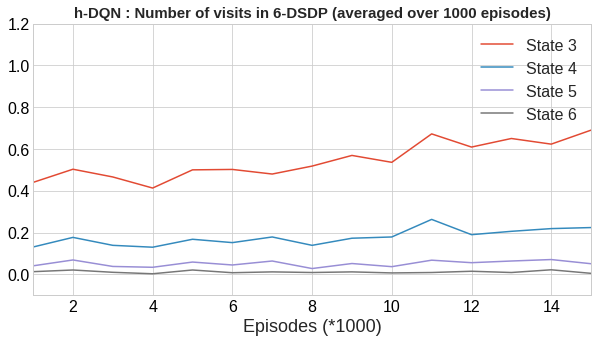

In [0]:
plot_visited_states(visits,15000)

In [0]:
hdqn = pd.DataFrame(stats.episode_rewards, columns=['rewards'])

hdqn.to_csv('./hdqn.csv')

In [0]:
hdqn = pd.DataFrame(visits, columns=['rewards'])

hdqn.to_csv('./hdqn.csv')

## **HDRQN**

In [0]:
!git clone https://github.com/transedward/pytorch-hdqn.git
import os 
os.chdir('./pytorch-hdqn/')

Cloning into 'pytorch-hdqn'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


In [0]:
import numpy as np
import random
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from utils.replay_memory import ReplayMemory, Transition

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

class Variable(autograd.Variable):
    def __init__(self, data, *args, **kwargs):
        if USE_CUDA:
            data = data.cuda()
        super(Variable, self).__init__(data, *args, **kwargs)

class MetaController(nn.Module):
    def __init__(self, in_features=6, out_features=6):
        """
        Initialize a Meta-Controller of Hierarchical DQN network for the diecreate mdp experiment
            in_features: number of features of input.
            out_features: number of features of output.
                Ex: goal for meta-controller or action for controller
        """
        super(MetaController, self).__init__()
        self.fc1 = nn.LSTM(in_features, 256)
        self.fc2 = nn.Linear(256, out_features)

    def forward(self, x):
        x = self.fc1(x.view(len(x), 1, -1))
        #print('R1'+str(np.shape(x[0])))
        x = F.relu(x[0])
        #print('R2'+str(np.shape(x)))
        out = self.fc2(x.squeeze(1))
        #print(out)
        #out = out.view(-1)
        #print('R3'+str(np.shape(out)))
        return out

class Controller(nn.Module):
    def __init__(self, in_features=12, out_features=2):
        """
        Initialize a Controller(given goal) of h-DQN for the diecreate mdp experiment
            in_features: number of features of input.
            out_features: number of features of output.
                Ex: goal for meta-controller or action for controller
        """
        super(Controller, self).__init__()
        self.fc1 = nn.LSTM(in_features, 256)
        self.fc2 = nn.Linear(256, out_features)

    def forward(self, x):
        x = self.fc1(x.view(len(x), 1, -1))
        #print('S1'+str(np.shape(x[0])))
        x = F.relu(x[0])
        #print('S2'+str(np.shape(x)))
        out = self.fc2(x.squeeze(1))
        #print(out)
        #out = out.view(-1)
        #print('S3'+str(np.shape(out)))
        return out

"""
    OptimizerSpec containing following attributes
        constructor: The optimizer constructor ex: RMSprop
        kwargs: {Dict} arguments for constructing optimizer
"""
OptimizerSpec = namedtuple("OptimizerSpec", ["constructor", "kwargs"])

class hDQN():
    """
    The Hierarchical-DQN Agent
    Parameters
    ----------
        optimizer_spec: OptimizerSpec
            Specifying the constructor and kwargs, as well as learning rate schedule
            for the optimizer
        num_goal: int
            The number of goal that agent can choose from
        num_action: int
            The number of action that agent can choose from
        replay_memory_size: int
            How many memories to store in the replay memory.
        batch_size: int
            How many transitions to sample each time experience is replayed.
    """
    def __init__(self,
                 optimizer_spec,
                 num_goal=6,
                 num_action=2,
                 replay_memory_size=10000,
                 batch_size=128):
        ###############
        # BUILD MODEL #
        ###############
        self.num_goal = num_goal
        self.num_action = num_action
        self.batch_size = batch_size
        # Construct meta-controller and controller
        self.meta_controller = MetaController().type(dtype)
        self.target_meta_controller = MetaController().type(dtype)
        self.controller = Controller().type(dtype)
        self.target_controller = Controller().type(dtype)
        # Construct the optimizers for meta-controller and controller
        self.meta_optimizer = optimizer_spec.constructor(self.meta_controller.parameters(), **optimizer_spec.kwargs)
        self.ctrl_optimizer = optimizer_spec.constructor(self.controller.parameters(), **optimizer_spec.kwargs)
        # Construct the replay memory for meta-controller and controller
        self.meta_replay_memory = ReplayMemory(replay_memory_size)
        self.ctrl_replay_memory = ReplayMemory(replay_memory_size)

    def get_intrinsic_reward(self, goal, state):
        return 1.0 if goal == state else 0.0

    def select_goal(self, state, epilson):
        sample = random.random()
        if sample > epilson:
            state = torch.from_numpy(state).type(dtype)
            # Use volatile = True if variable is only used in inference mode, i.e. donâ€™t save the history
            return self.meta_controller(Variable(state, volatile=True)).data.max(1)[1].cpu()
        else:
            return torch.IntTensor([random.randrange(self.num_goal)])

    def select_action(self, joint_state_goal, epilson):
        sample = random.random()
        if sample > epilson:
            joint_state_goal = torch.from_numpy(joint_state_goal).type(dtype)
            # Use volatile = True if variable is only used in inference mode, i.e. donâ€™t save the history
            return self.controller(Variable(joint_state_goal, volatile=True)).data.max(1)[1].cpu()
        else:
            return torch.IntTensor([random.randrange(self.num_action)])

    def update_meta_controller(self, gamma=1.0):
        if len(self.meta_replay_memory) < self.batch_size:
            return
        state_batch, goal_batch, next_state_batch, ex_reward_batch, done_mask = \
            self.meta_replay_memory.sample(self.batch_size)
        state_batch = Variable(torch.from_numpy(state_batch).type(dtype))
        goal_batch = Variable(torch.from_numpy(goal_batch).long())
        next_state_batch = Variable(torch.from_numpy(next_state_batch).type(dtype))
        ex_reward_batch = Variable(torch.from_numpy(ex_reward_batch).type(dtype))
        not_done_mask = Variable(torch.from_numpy(1 - done_mask)).type(dtype)
        if USE_CUDA:
            goal_batch = goal_batch.cuda()
        # Compute current Q value, meta_controller takes only state and output value for every state-goal pair
        # We choose Q based on goal chosen.
        current_Q_values = self.meta_controller(state_batch).gather(1, goal_batch.unsqueeze(1))
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = self.target_meta_controller(next_state_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = ex_reward_batch + (gamma * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values)

        # Copy Q to target Q before updating parameters of Q
        self.target_meta_controller.load_state_dict(self.meta_controller.state_dict())
        # Optimize the model
        self.meta_optimizer.zero_grad()
        loss.backward()
        for param in self.meta_controller.parameters():
            param.grad.data.clamp_(-1, 1)
        self.meta_optimizer.step()

    def update_controller(self, gamma=1.0):
        if len(self.ctrl_replay_memory) < self.batch_size:
            return
        state_goal_batch, action_batch, next_state_goal_batch, in_reward_batch, done_mask = \
            self.ctrl_replay_memory.sample(self.batch_size)
        state_goal_batch = Variable(torch.from_numpy(state_goal_batch).type(dtype))
        action_batch = Variable(torch.from_numpy(action_batch).long())
        next_state_goal_batch = Variable(torch.from_numpy(next_state_goal_batch).type(dtype))
        in_reward_batch = Variable(torch.from_numpy(in_reward_batch).type(dtype))
        not_done_mask = Variable(torch.from_numpy(1 - done_mask)).type(dtype)
        if USE_CUDA:
            action_batch = action_batch.cuda()
        # Compute current Q value, controller takes only (state, goal) and output value for every (state, goal)-action pair
        # We choose Q based on action taken.
        current_Q_values = self.controller(state_goal_batch).gather(1, action_batch.unsqueeze(1))
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = self.target_controller(next_state_goal_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = in_reward_batch + (gamma * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values)

        # Copy Q to target Q before updating parameters of Q
        self.target_controller.load_state_dict(self.controller.state_dict())
        # Optimize the model
        self.ctrl_optimizer.zero_grad()
        loss.backward()
        for param in self.controller.parameters():
            param.grad.data.clamp_(-1, 1)
        self.ctrl_optimizer.step()


In [0]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

import torch.optim as optim

from envs.mdp import StochasticMDPEnv
#from agents.hdqn_mdp import hDQN, OptimizerSpec
from utils.plotting import plot_episode_stats, plot_visited_states
from utils.schedule import LinearSchedule

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


NUM_EPISODES = 15000
BATCH_SIZE = 128
GAMMA = 1.0
REPLAY_MEMORY_SIZE = 1000000
LEARNING_RATE = 0.00025
ALPHA = 0.95
EPS = 0.01

optimizer_spec = OptimizerSpec(
    constructor=optim.RMSprop,
    kwargs=dict(lr=LEARNING_RATE, alpha=ALPHA, eps=EPS),
)

exploration_schedule = LinearSchedule(50000, 0.1, 1)

agent = hDQN(
    optimizer_spec=optimizer_spec,
    replay_memory_size=REPLAY_MEMORY_SIZE,
    batch_size=BATCH_SIZE,
)

env = StochasticMDPEnv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
agent, stats, visits, = hdqn_learning(
    env=env,
    agent=agent,
    num_episodes=NUM_EPISODES,
    exploration_schedule=exploration_schedule,
    gamma=GAMMA,
)

In [0]:
hdrqn = pd.DataFrame(stats.episode_rewards, columns=['rewards'])

hdrqn.to_csv('./hdrqn.csv')

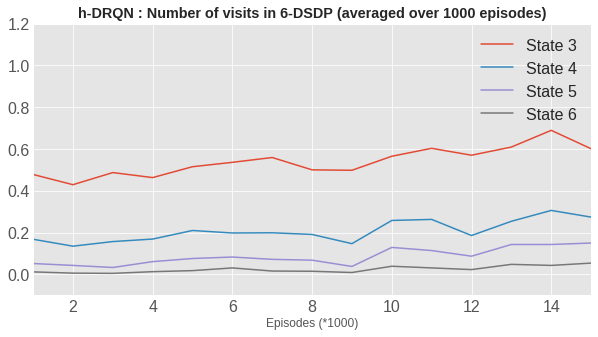

In [0]:
def plot_visited_states(visits, num_episodes):
    n_thousand_episode = int(np.floor(num_episodes / 1000))
    eps = list(range(1, n_thousand_episode + 1))

    plt.figure(figsize=(10,5))
    for i_state in range(2, 6):
        state_label = "State %d" % (i_state + 1)
        plt.plot(eps, visits[:, i_state]/1000, label=state_label)

    plt.legend()
    plt.xlabel("Episodes (*1000)")
    plt.ylim(-0.1, 1.2)
    plt.xlim(1, 15)
    plt.title("h-DRQN : Number of visits in 6-DSDP (averaged over 1000 episodes)")
    plt.grid(True)
    plt.savefig("./plot_visited_states.png")
    
plot_visited_states(visits,15000)

## **DRQN**

In [0]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

from envs.mdp import StochasticMDPEnv
from utils.plotting import plot_episode_stats, plot_visited_states
from utils.schedule import LinearSchedule

from q_learning import q_learning

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
NUM_EPISODES = 15000
exploration_schedule = LinearSchedule(50000, 0.1, 1.0)

env = StochasticMDPEnv()

In [0]:
Q, stats, visits = q_learning(env, NUM_EPISODES, lr=0.00025, exploration_schedule=exploration_schedule)

In [0]:
drqn = pd.DataFrame(stats.episode_rewards, columns=['rewards'])

drqn.to_csv('./drqn.csv')

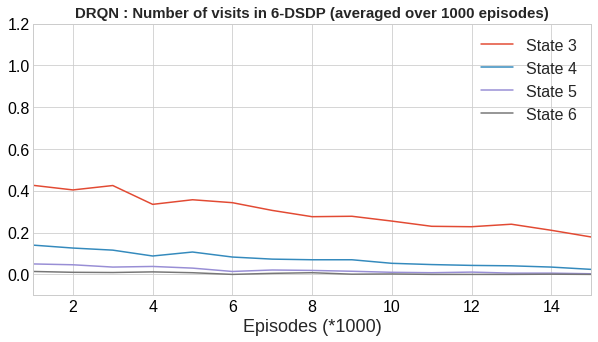

In [0]:
plot_visited_states(visits,15000)

In [0]:
visits

array([[1.000e+03, 1.322e+03, 4.260e+02, 1.400e+02, 5.000e+01, 1.400e+01],
       [1.000e+03, 1.314e+03, 4.040e+02, 1.260e+02, 4.600e+01, 1.000e+01],
       [1.000e+03, 1.335e+03, 4.250e+02, 1.160e+02, 3.500e+01, 9.000e+00],
       [1.000e+03, 1.273e+03, 3.350e+02, 8.800e+01, 3.800e+01, 1.200e+01],
       [1.000e+03, 1.272e+03, 3.570e+02, 1.070e+02, 3.000e+01, 8.000e+00],
       [1.000e+03, 1.274e+03, 3.430e+02, 8.300e+01, 1.400e+01, 0.000e+00],
       [1.000e+03, 1.249e+03, 3.060e+02, 7.300e+01, 2.100e+01, 5.000e+00],
       [1.000e+03, 1.217e+03, 2.760e+02, 7.000e+01, 1.900e+01, 8.000e+00],
       [1.000e+03, 1.222e+03, 2.780e+02, 7.000e+01, 1.500e+01, 1.000e+00],
       [1.000e+03, 1.210e+03, 2.550e+02, 5.300e+01, 1.000e+01, 2.000e+00],
       [1.000e+03, 1.191e+03, 2.300e+02, 4.700e+01, 8.000e+00, 0.000e+00],
       [1.000e+03, 1.196e+03, 2.280e+02, 4.300e+01, 1.100e+01, 0.000e+00],
       [1.000e+03, 1.205e+03, 2.400e+02, 4.100e+01, 6.000e+00, 0.000e+00],
       [1.000e+03, 1.181e